In [1]:
import os
from glob import glob
import numpy as np
import h5py
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
import function.utils as ut
from decoder.manifold import SpatialDecoder
from decoder.metrics import get_error

## Load data

In [2]:
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}

datapath = alldata['Enriched'][2]
day = 1  # Recording days, None for all days
min_rate = 1/60  # 1/60  # Minimum transient rate for active cells
ybin = 80  # Number of spatial bins
ysigma = 2  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

In [3]:
data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate, verbose=True)

with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # Dataset dependent
    
print('Recording days:', days)
print('Context fam/nov:', ctx)

------------------------------------
Total cells: 97
Active cells: 77
Proportion of active cells 79.38 %
Active in both 36.08 %
Active exclusively in Fam 19.59 %
Active exclusively in Nov 23.71 %
------------------------------------
Recording days: [1 1 1 1]
Context fam/nov: [0 1 0 1]


## Prepare data (spatial tuning)

In [4]:
tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                           spike=False, transient=True)
## Clipping normalization
# tuning_ = tf.normalize_tuning(tuning, prct=99)

In [5]:
def collect_data(tuning, ctx=np.array([0,1,0,1]), ybin=80):
    
    y_edges = np.linspace(0,4,ybin+1)  # Unify position data to (0,4)
    y_centers = (y_edges[:-1] + y_edges[1:])/2
    Fdata, ydata  = [], []
    for c in range(len(set(ctx))):
        F = np.concatenate([tuning[k] for k in np.where(ctx==c)[0]], axis=2)  # (ncell, ybin, ntrial)
        Fdata.append(np.transpose(F, (2,1,0)))  # (ntrial, ybin, ncell)
        ydata.append(np.tile(y_centers, (F.shape[2],1)))  # (ntrial, ybin)
        
    return Fdata, ydata

Fdata, ydata = collect_data(tuning, ctx=ctx, ybin=ybin)

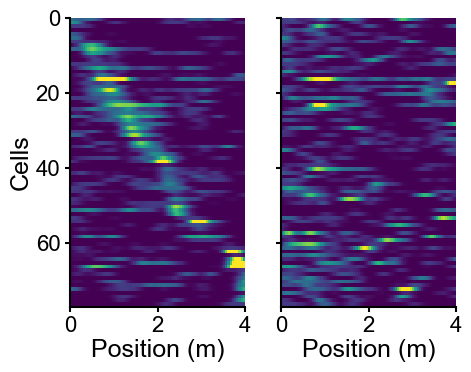

In [6]:
def display_tuning(Fdata, sort=0):
    
    tuning_mean = [F.mean(axis=0).T for F in Fdata]
    ncell = tuning_mean[0].shape[0]
    order = ut.sort_tuning(tuning_mean[sort])[1]
    vmax = np.percentile(np.hstack([M.ravel() for M in tuning_mean]), 99.5)
    
    fig, axs = plt.subplots(1,len(Fdata),figsize=(5,4),sharey=True)
    for c, M in enumerate(tuning_mean):
        axs[c].imshow(M[order], interpolation='none', vmin=0, vmax=vmax, extent=[0,4,ncell,0])
        axs[c].set_aspect('auto')
        axs[c].set_xlabel('Position (m)')
    axs[0].set_ylabel('Cells')
    fig.tight_layout()
    # fig.savefig('Test.svg')
    
display_tuning(Fdata, sort=0)

## Useful functions

In [7]:
def prepare_data(Fs, ys, trial=None):
    '''
    Parameters
    ----------
    Fs : numpy array (ntrial, ybin, ncell)
        Spatial tuning of a given mouse with all trials stacked along axis=0
    ys : numpy array (ntrial, ybin)
        Position vector of each trial
    trial : numpy 1d array
        Indices of selected trials

    Returns
    -------
    X : array (n_samples, ncell)
    y : array (n_samples,) 
        where n_samples = ntrial * ybin
    '''
    if trial is None:  # Take all trials
        trial = np.arange(Fs.shape[0])
    elif isinstance(trial, int):
        trial = [trial]   
    X = np.vstack([Fs[r,:,:] for r in trial])
    y = np.hstack([ys[r,:] for r in trial])
    
    ## Discard points where all cells are silent
    silent = (X.sum(axis=1) == 0)
    if np.any(silent):
        X = X[~silent,:]
        y = y[~silent]
        
    return X, y

def shuffle_trial(Fs, seed=0):
    '''For each cell, shuffle the trial ID while keep the spatial tuning.
    '''
    rng = np.random.default_rng(seed)
    Fshuffled = Fs.copy()  # (ntrial, ybin, ncell)
    for i in range(Fs.shape[2]):
        Fshuffled[:,:,i] = rng.permutation(Fs[:,:,i])  # Shuffle by rows (trials)
        
    return Fshuffled

def shuffle_position(ys, seed=0):
    '''For each trial, circularly shuffle the position vector.
    '''
    rng = np.random.default_rng(seed)
    yshuffled = ys.copy()
    for r in range(ys.shape[0]):
        t = rng.choice(ys.shape[1])
        yshuffled[r,:] = np.hstack([ys[r,t:], ys[r,:t]])
    
    return yshuffled

def decode_position_cv(Fs, ys, nfold=10, y2cm=100, **kwargs):
    
    error = []
    cv = KFold(n_splits=nfold, shuffle=False)
    
    for train_set, test_set in cv.split(np.zeros((Fs.shape[0],1))): 
    
        X_train, y_train = prepare_data(Fs, ys, trial=train_set)
        X_test, y_test = prepare_data(Fs, ys, trial=test_set)
        
        spd = SpatialDecoder(**kwargs)
        spd.fit(X_train, y_train)
        y_pred = spd.predict(X_test)
        error.append(y2cm*get_error(y_test, y_pred, kind='median'))
    
    return np.array(error)

def decode_position(Fdata, ydata, nfold=10, yrange=(0,4), ybin=80, seed=0, **kwargs):
    
    error = [[] for _ in range(len(Fdata))]
    
    for c in range(len(Fdata)):
        
        error[c].append(decode_position_cv(
            Fdata[c], ydata[c], nfold=nfold, yrange=yrange, ybin=ybin, **kwargs))
        
        ## Shuffle trials
        Fshuffled = shuffle_trial(Fdata[c], seed=seed)
        error[c].append(decode_position_cv(
            Fshuffled, ydata[c], nfold=nfold, yrange=yrange, ybin=ybin, **kwargs))
        
        ## Shuffle position
        yshuffled = shuffle_position(ydata[c], seed=seed)
        error[c].append(decode_position_cv(
            Fdata[c], yshuffled, nfold=nfold, yrange=yrange, ybin=ybin, **kwargs))
        
        error[c] = np.vstack(error[c])  # (3, nfold) array
        
    return error

## Decode position

In [8]:
params = dict(method='knr', k=10, knr_metric='cosine', reduction='none')  # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian
              
error = decode_position(
    Fdata, ydata, nfold=10, yrange=(0,4), ybin=ybin, ctx=ctx, seed=0, **params)

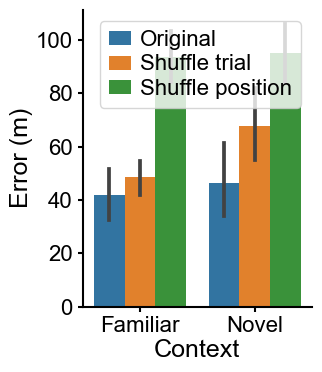

In [9]:
df = ut.long_dataframe(error, varnames=['Context','Data','Error'],
                       varvalues=[['Familiar','Novel'],
                                  ['Original','Shuffle trial','Shuffle position'],None])

fig, ax = plt.subplots(figsize=(3.5,4))
sns.barplot(df, x='Context', y='Error', hue='Data', ax=ax)
ax.set(ylabel='Error (m)')
ax.legend()
fig.tight_layout()

## Get cell importance and decode position from sub-population

In [10]:
def cell_importance(Fdata, ydata, nfold=10, yrange=(0,4), ybin=80, **kwargs):
    
    importance = [[] for _ in range(len(Fdata))]
    
    for c in range(len(Fdata)):
        print('Decoding context %d ...' % c)
        error = decode_position_cv(
            Fdata[c], ydata[c], nfold=nfold, yrange=yrange, ybin=ybin, **kwargs)
    
        ncell = Fdata[c].shape[2]
        error_cell = [[] for _ in range(ncell)]
        for i in range(ncell):
            ind = np.setdiff1d(np.arange(ncell), i)
            F = Fdata[c][:,:,ind]  # Remove the i-th cell
            error_cell[i] = decode_position_cv(
                F, ydata[c], nfold=nfold,  yrange=yrange, ybin=ybin, **kwargs)
        error_cell = np.vstack(error_cell)  # (ncell, ntrial)
        importance[c] = np.mean(error_cell, axis=1) - np.mean(error)
        importance[c] /= np.std(importance[c])
    
    return np.column_stack(importance)

params = dict(method='knr', k=10, knr_metric='cosine', reduction='none')  # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian
importance = cell_importance(Fdata, ydata, nfold=10, yrange=(0,4), ybin=ybin, **params)  # (ncell, nctx)

Decoding context 0 ...
Decoding context 1 ...


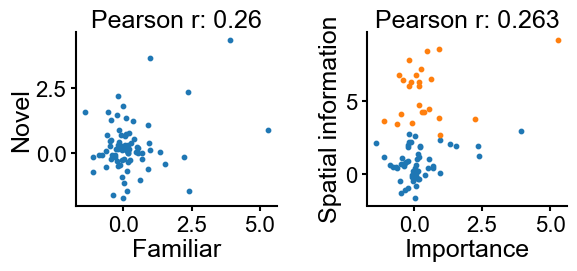

In [17]:
pval_thr = 0.01
c = 0
imp = importance[:,c]  # importance.mean(axis=1)
si = cells['si_unbiased'][:,c]  # cells['si_unbiased'].mean(axis=1)
pc = (cells['si_pvalue'][:,c] <= pval_thr)

fig, axs = plt.subplots(1,2,figsize=(6,3))
axs[0].scatter(importance[:,0], importance[:,1], s=10)
axs[0].set_title('Pearson r: %.3g' % pearsonr(importance[:,0], importance[:,1])[0])
axs[0].set(xlabel='Familiar', ylabel='Novel')
axs[1].scatter(imp[~pc], si[~pc], s=10, c='C0')
axs[1].scatter(imp[pc], si[pc], s=10, c='C1')
axs[1].set_title('Pearson r: %.3g' % pearsonr(imp, si)[0])
axs[1].set(xlabel='Importance', ylabel='Spatial information')
fig.tight_layout()

In [18]:
np.where(imp > 1)[0]

array([ 4, 16, 26, 38, 50, 51, 53], dtype=int64)

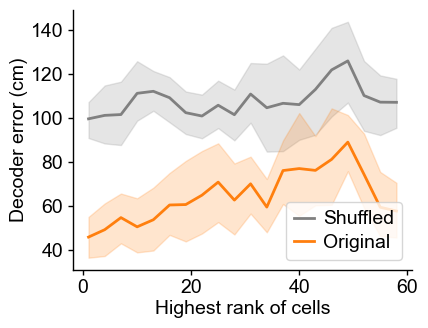

In [84]:
def decode_sub_population(Fs, ys, rank, nsub=20, step=5, nfold=10,
                          seed=0, palette=['C0','gray'], **kwargs):
    ntrial, ybin, ncell = Fs.shape
    nset = (ncell - nsub) // step + 1
    highest_rank = [1+s*step for s in range(nset)]
    yshuffled = shuffle_position(ys, seed=seed)
    errors = np.zeros((nset, nfold))
    errors_shuffled = np.zeros((nset, nfold))
    
    for s in range(nset):
        ind = rank[slice(s*step, s*step+nsub)]
        Fbis = Fs[:,:,ind]  # Take a sub population of cells
        errors[s] = decode_position_cv(Fbis, ys, nfold=nfold, **kwargs)
        errors_shuffled[s] = decode_position_cv(Fbis, yshuffled, nfold=nfold, **kwargs)
     
    df_errors = pd.DataFrame({'Error': errors.ravel(),
                              'Rank': np.repeat(highest_rank, nfold)})
    df_errors_shuffled = pd.DataFrame({'Error': errors_shuffled.ravel(),
                                       'Rank': np.repeat(highest_rank, nfold)})
    
    fig, ax = plt.subplots(figsize=(4.5,3.5))
    sns.lineplot(data=df_errors_shuffled, x='Rank', y='Error', ax=ax, color=palette[1])
    sns.lineplot(data=df_errors, x='Rank', y='Error', ax=ax, color=palette[0])
    ax.set(xlabel='Highest rank of cells', ylabel='Decoder error (cm)')
    ax.legend(['Shuffled','Original'], loc='lower right')
    fig.tight_layout()

    return df_errors, df_errors_shuffled

rank = np.argsort(importance[:,1])[::-1]  # Cell indices of decreasing importance
params = dict(method='knr', k=10, knr_metric='cosine', reduction='none')  # 'knr'|'gpr'|'svr'|'pvcorr'|'bayesian
df_errors, df_errors_shuffled = decode_sub_population(
    Fdata[1], ydata[1], rank, nsub=30, step=3, nfold=10, seed=0,
    palette=['tab:orange','gray'], **params)